In [11]:
import os
import math
import time
import pickle
import json
import spacy
import requests
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_palette('colorblind', 20, 0.75)
from time import sleep
import matplotlib.pyplot as plt
import matplotlib as mpl
from bs4 import BeautifulSoup

from nltk.corpus import stopwords
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MultiLabelBinarizer
from sklearn.feature_selection import SelectKBest
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold, StratifiedKFold
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB, BernoulliNB, GaussianNB
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, roc_curve, f1_score, precision_score, recall_score, roc_auc_score, confusion_matrix
from sklearn.feature_extraction import DictVectorizer

# plt.style.use('fivethirtyeight')
%matplotlib inline

In [12]:
def save_file(obj, name) :
    '''
        Function to save data as pickle file
    '''
    with open('data/'+ name + '.pkl', 'wb') as f:
        pickle.dump(obj, f)

def load_file(name):
    '''
        Function to load data from pickle file
    '''
    with open('data/' + name + '.pkl', 'rb') as f:
        return pickle.load(f)

**Load and clean data**

In [13]:
col_names = ['Id', 'label', 'statement', 'subjects', 'speaker', 'job_title', 'state', 'party', 'barely_true', 
             'false', 'half_true', 'mostly_true', 'pants_on_fire', 'context']
train_path = './data/train.tsv'
valid_path = './data/valid.tsv'
test_path = './data/test.tsv'
news_train = pd.read_csv(train_path, sep="\t", header=None, names=col_names, na_values=['none', 'None'])
news_valid = pd.read_csv(valid_path, sep="\t", header=None, names=col_names, na_values=['none', 'None'])
news_test = pd.read_csv(test_path, sep="\t", header=None, names=col_names, na_values=['none', 'None'])

In [14]:
news_train.sample(3)

,Id,label,statement,subjects,speaker,job_title,state,party,barely_true,false,half_true,mostly_true,pants_on_fire,context
2210,3554.json,false,Austins Pease Elementary is a school that was ...,education,meria-carstarphen,"Superintendent, Austin Independent School Dist...",Texas,NaN,0.0,1.0,0.0,0.0,0.0,a radio interview.
7633,7860.json,true,"During the Civil War, more than 300,000 Ohioan...",history,keith-faber,State senator,Ohio,republican,0.0,0.0,1.0,0.0,0.0,remarks at a General Assembly session
1370,13041.json,pants-fire,Says Hillary Clinton has not answered a single...,immigration,donald-trump,President-Elect,New York,republican,63.0,114.0,51.0,37.0,61.0,an immigration policy speech in Phoenix


In [15]:
news_train.shape

(10240, 14)

In [16]:
news_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10240 entries, 0 to 10239
Data columns (total 14 columns):
Id               10240 non-null object
label            10240 non-null object
statement        10240 non-null object
subjects         10238 non-null object
speaker          10238 non-null object
job_title        7340 non-null object
state            8030 non-null object
party            8494 non-null object
barely_true      10238 non-null float64
false            10238 non-null float64
half_true        10238 non-null float64
mostly_true      10238 non-null float64
pants_on_fire    10238 non-null float64
context          10138 non-null object
dtypes: float64(5), object(9)
memory usage: 1.1+ MB


In [17]:
# Remove Id column
news_train.drop('Id', axis=1, inplace=True)

In [18]:
news_train[news_train.subjects.isnull()]

,label,statement,subjects,speaker,job_title,state,party,barely_true,false,half_true,mostly_true,pants_on_fire,context
2142,false,The fact is that although we have had a presid...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9375,false,"Joe, I keep hearing you every morning talking ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [19]:
# Remove the 2 rows that have no meta data
news_train = news_train[~news_train.subjects.isnull()]

In [20]:
news_train.label.unique() # all the labels belong to one of the six classes

array(['false', 'half-true', 'mostly-true', 'true', 'barely-true',
       'pants-fire'], dtype=object)

In [21]:
subjects_list = []
for subj in news_train.subjects:
    subjects_list.extend(subj.split(','))
unique_subjects = set(subjects_list)
print ('number of subjects:', len(unique_subjects))
print (unique_subjects)

number of subjects: 142
{'disability', 'message-machine', 'government-regulation', 'food', 'natural-disasters', 'guns', 'gas-prices', 'science', 'census', 'sexuality', 'florida-amendments', 'weather', 'income', 'fake-news', 'unions', 'water', 'criminal-justice', 'health-care', 'medicaid', 'obama-birth-certificate', 'county-budget', 'sotomayor-nomination', 'social-security', 'education', 'city-budget', 'terrorism', 'stimulus', 'technology', 'pundits', 'consumer-safety', 'county-government', 'jobs', 'china', 'sports', 'baseball', 'legal-issues', 'public-service', 'colbert-report', 'state-budget', 'gambling', 'bankruptcy', 'workers', 'urban', 'kagan-nomination', 'public-safety', 'market-regulation', 'nuclear', 'ebola', 'veterans', 'energy', 'patriotism', 'Alcohol', 'small-business', 'financial-regulation', 'federal-budget', 'pensions', 'population', 'recreation', 'corrections-and-updates', 'florida', 'congressional-rules', 'death-penalty', 'states', 'marriage', 'diversity', 'climate-chang

In [22]:
news_train.party.unique()

array(['republican', 'democrat', nan, 'organization', 'independent',
       'columnist', 'activist', 'talk-show-host', 'libertarian',
       'newsmaker', 'journalist', 'labor-leader', 'state-official',
       'business-leader', 'education-official', 'tea-party-member',
       'green', 'liberal-party-canada', 'government-body', 'Moderate',
       'democratic-farmer-labor', 'ocean-state-tea-party-action',
       'constitution-party'], dtype=object)

In [23]:
# replace missing values with 'NA'
news_train.loc[news_train.party.isnull(),'party'] = 'NA'
news_train.loc[news_train.job_title.isnull(),'job_title'] = 'NA'
news_train.loc[news_train.context.isnull(),'context'] = 'NA'
news_train.loc[news_train.state.isnull(),'state'] = 'NA'

In [24]:
# remove leading and trailing whitespace
news_train["state"] = news_train["state"].map(str.strip)
news_train.state.unique()

array(['Texas', 'Virginia', 'Illinois', 'NA', 'Florida', 'Wisconsin',
       'New Jersey', 'Vermont', 'Massachusetts', 'Maryland',
       'Washington, D.C.', 'Oregon', 'New York', 'California', 'Missouri',
       'Rhode Island', 'West Virginia', 'Arkansas', 'New Hampshire',
       'Ohio', 'Georgia', 'Arizona', 'Wyoming', 'Delaware', 'Kentucky',
       'Kansas', 'ohio', 'Colorado', 'North Carolina', 'New Mexico',
       'Alaska', 'South Carolina', 'Minnesota', 'Tennessee',
       'Pennsylvania', 'Iowa', 'Connecticut', 'Louisiana', 'Indiana',
       'Utah', 'Michigan', 'Oklahoma', 'Nevada', 'Virgina', 'Nebraska',
       'Washington D.C.', 'Alabama', 'Russia', 'Washington state',
       'Washington', 'District of Columbia', 'Unknown', 'Mississippi',
       'Rhode island', 'China', 'United Kingdom', 'South Dakota', 'Qatar',
       'Montana', 'North Dakota', 'Idaho', 'Maine',
       'Virginia director, Coalition to Stop Gun Violence', 'Virgiia',
       'Hawaii', 'Atlanta', 'Tennesse', 'Wash

In [25]:
# cleaning the state column for training data
news_train.loc[news_train.state == 'Unknown','state'] = 'NA'
news_train.loc[news_train.state == 'PA - Pennsylvania','state'] = 'Pennsylvania'
news_train.loc[news_train.state == 'Virgiia','state'] = 'Virginia'
news_train.loc[news_train.state == 'Virginia director, Coalition to Stop Gun Violence','job_title'] = 'Virginia director, Coalition to Stop Gun Violence'
news_train.loc[news_train.state == 'Virginia director, Coalition to Stop Gun Violence','state'] = 'Virginia'
news_train.loc[news_train.state == 'Virgina','state'] = 'Virginia'
news_train.loc[news_train.state == 'Tex','state'] = 'Texas'
news_train.loc[news_train.state == 'Washington, D.C.','state'] = 'Washington DC'
news_train.loc[news_train.state == 'Washington D.C.','state'] = 'Washington DC'
news_train.loc[news_train.state == 'District of Columbia','state'] = 'Washington DC'
news_train.loc[news_train.state == 'Washington state','state'] = 'Washington'
news_train.loc[news_train.state == 'Rhode island','state'] = 'Rhode Island'
news_train.loc[news_train.state == 'ohio','state'] = 'Ohio'

In [26]:
# clean validation data
news_valid.loc[news_valid.party.isnull(),'party'] = 'NA'
news_valid.loc[news_valid.job_title.isnull(),'job_title'] = 'NA'
news_valid.loc[news_valid.context.isnull(),'context'] = 'NA'
news_valid.loc[news_valid.state.isnull(),'state'] = 'NA'

In [27]:
# cleaning the state column for validation data
news_valid["state"] = news_valid["state"].map(str.strip)
news_valid.loc[news_valid.state == 'District of Columbia','state'] = 'Washington DC'
news_valid.loc[news_valid.state == 'Washington, D.C.','state'] = 'Washington DC'
news_valid.loc[news_valid.state == 'ohio','state'] = 'Ohio'
print (news_valid.state.unique())

['Missouri' 'NA' 'Oregon' 'Illinois' 'New Hampshire' 'Tennessee'
 'New York' 'Texas' 'Virginia' 'Georgia' 'Delaware' 'Washington DC'
 'Rhode Island' 'Florida' 'Wisconsin' 'Arizona' 'Massachusetts' 'Ohio'
 'South Carolina' 'New Jersey' 'California' 'Pennsylvania' 'Russia'
 'Kentucky' 'Louisiana' 'New Mexico' 'Colorado' 'Vermont' 'Minnesota'
 'Arkansas' 'Michigan' 'Maryland' 'Oklahoma' 'Iowa' 'Utah' 'Indiana'
 'North Carolina' 'Alaska' 'Washington' 'Nevada' 'Connecticut'
 'North Dakota' 'Kansas' 'Alabama' 'West Virginia']


In [28]:
# clean test data
news_test.loc[news_test.party.isnull(),'party'] = 'NA'
news_test.loc[news_test.job_title.isnull(),'job_title'] = 'NA'
news_test.loc[news_test.context.isnull(),'context'] = 'NA'
news_test.loc[news_test.state.isnull(),'state'] = 'NA'

In [29]:
# cleaning the state column for test data
news_test["state"] = news_test["state"].map(str.strip)
news_test.loc[news_test.state == 'District of Columbia','state'] = 'Washington DC'
news_test.loc[news_test.state == 'Washington, D.C.','state'] = 'Washington DC'
news_test.loc[news_test.state == 'Washington D.C.','state'] = 'Washington DC'
news_test.loc[news_test.state == 'ohio','state'] = 'Ohio'
news_test.loc[news_test.state == 'Unknown','state'] = 'NA'

print (news_test.state.unique())

['Texas' 'Wisconsin' 'New York' 'Oregon' 'Rhode Island' 'Tennessee' 'Ohio'
 'Indiana' 'Georgia' 'NA' 'Pennsylvania' 'Alaska' 'North Carolina'
 'Florida' 'South Carolina' 'Colorado' 'Illinois' 'Virginia'
 'New Hampshire' 'Massachusetts' 'Minnesota' 'New Jersey' 'Arizona'
 'Delaware' 'New Mexico' 'Washington DC' 'Kentucky' 'Utah' 'Vermont'
 'Missouri' 'West Virginia' 'California' 'Maryland' 'Connecticut'
 'South Dakota' 'Nevada' 'Alabama' 'Michigan' 'Louisiana' 'Iowa'
 'Arkansas' 'Washington' 'Kansas']


**Take a look at some examples in each class**

In [20]:
news_train[news_train.label == 'pants-fire']['statement'].iloc[0]

'In the case of a catastrophic event, the Atlanta-area offices of the Centers for Disease Control and Prevention will self-destruct.'

In [21]:
news_train[news_train.label == 'false']['statement'].iloc[0]

'Says the Annies List political group supports third-trimester abortions on demand.'

In [22]:
news_train[news_train.label == 'barely-true']['statement'].iloc[0]

'Jim Dunnam has not lived in the district he represents for years now.'

In [23]:
news_train[news_train.label == 'half-true']['statement'].iloc[0]

'When did the decline of coal start? It started when natural gas took off that started to begin in (President George W.) Bushs administration.'

In [24]:
news_train[news_train.label == 'mostly-true']['statement'].iloc[0]

'Hillary Clinton agrees with John McCain "by voting to give George Bush the benefit of the doubt on Iran."'

In [25]:
news_train[news_train.label == 'true']['statement'].iloc[0]

'The Chicago Bears have had more starting quarterbacks in the last 10 years than the total number of tenured (UW) faculty fired during the last two decades.'

**EDA & Feature engineering**

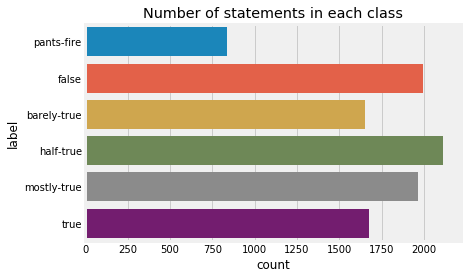

In [71]:
# distribution of classes
order_of_labels = ['pants-fire', 'false', 'barely-true', 'half-true', 'mostly-true', 'true']
sns.countplot(y="label", data=news_train, order=order_of_labels)
plt.title('Number of statements in each class')
plt.show()

/Users/joshuamei/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


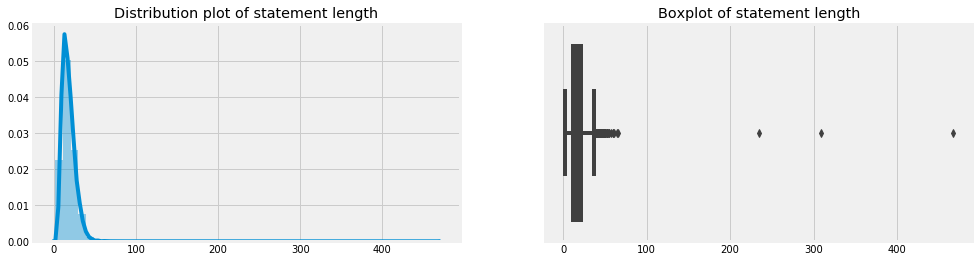

In [27]:
# length of statement
statement_length = [len(x.split()) for x in news_train['statement']]
plt.figure(figsize=(15,4))
plt.subplot(121)
sns.distplot(statement_length)
plt.title('Distribution plot of statement length')
plt.subplot(122)
sns.boxplot(statement_length)
plt.title('Boxplot of statement length')
plt.show()

In [28]:
news_train['statement_length'] = statement_length

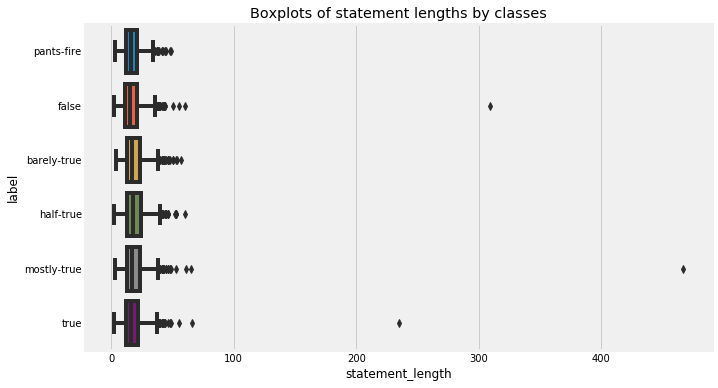

In [72]:
plt.figure(figsize=(10,6))
sns.boxplot(x='statement_length', y='label', data=news_train, order=order_of_labels)
plt.title('Boxplots of statement lengths by classes')
plt.show()

In [32]:
# number of unique words in the statement
news_train['unique_words'] = [len(np.unique(value.split())) for value in news_train.statement]

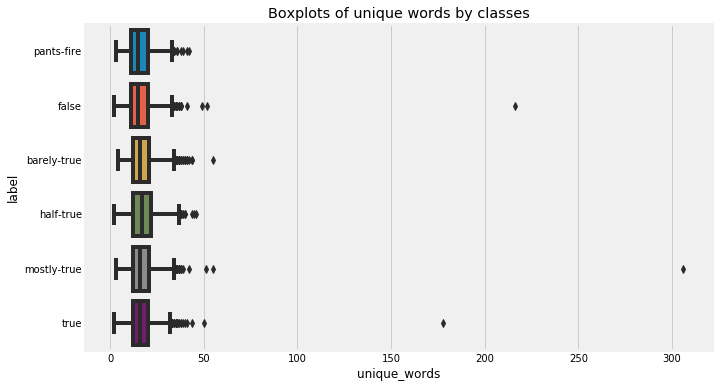

In [46]:
plt.figure(figsize=(10,6))
sns.boxplot(x='unique_words', y='label', data=news_train, order=order_of_labels)
plt.title('Boxplots of unique words by classes')
plt.show()

In [45]:
# python -m spacy download en_core_web_sm
nlp = spacy.load("en_core_web_sm")

In [48]:
# parsing each statement
parsed_statement = []
for i, parsed in enumerate(nlp.pipe(news_train.statement.values, batch_size=50, n_threads=4)):
    assert parsed.is_parsed
    if (i % 1000) == 0:
        print(i)
    parsed_statement.append(parsed)   

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000


In [49]:
# get the unique parts of speech
unique_pos = []
for parsed in parsed_statement:
    unique_pos.extend([t.pos_ for t in parsed])
unique_pos = np.unique(unique_pos)
print(unique_pos)

['ADJ' 'ADP' 'ADV' 'CCONJ' 'DET' 'INTJ' 'NOUN' 'NUM' 'PART' 'PRON' 'PROPN'
 'PUNCT' 'SPACE' 'SYM' 'VERB' 'X']


In [37]:
# initialize the parts of speech columns
for pos in unique_pos:
    news_train[pos+'_prop'] = 0.

In [43]:
# calculate the proportion of each POS in the statement
news_train = news_train.reset_index(drop=True)
for i, parsed in enumerate(parsed_statement):
    if (i % 100) == 0:
        print(i, end=' ')
    parsed_len = len(parsed)
    for pos in unique_pos:
        count = len([token for token in parsed if token.pos_ == pos])
        news_train.loc[i, pos+'_prop'] = float(count)/parsed_len

0 100 200 300 400 500 600 700 800 900 1000 1100 1200 1300 1400 1500 1600 1700 1800 1900 2000 2100 2200 2300 2400 2500 2600 2700 2800 2900 3000 3100 3200 3300 3400 3500 3600 3700 3800 3900 4000 4100 4200 4300 4400 4500 4600 4700 4800 4900 5000 5100 5200 5300 5400 5500 5600 5700 5800 5900 6000 6100 6200 6300 6400 6500 6600 6700 6800 6900 7000 7100 7200 7300 7400 7500 7600 7700 7800 7900 8000 8100 8200 8300 8400 8500 8600 8700 8800 8900 9000 9100 9200 9300 9400 9500 9600 9700 9800 9900 10000 10100 10200 

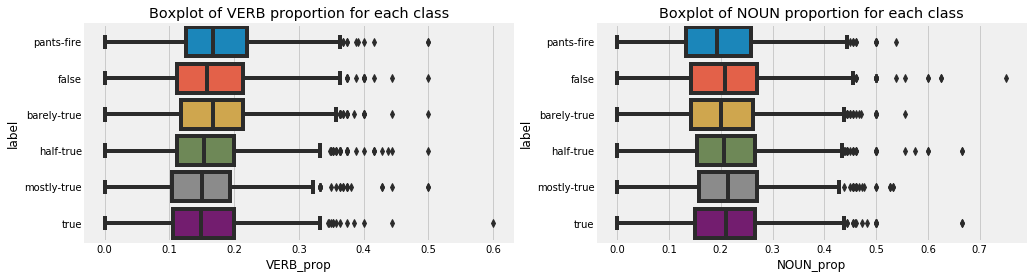

In [47]:
plt.figure(figsize=(15,4))
plt.subplot(121)
sns.boxplot(x='VERB_prop', y='label', data=news_train, order=order_of_labels)
plt.title('Boxplot of VERB proportion for each class')
plt.subplot(122)
sns.boxplot(x='NOUN_prop', y='label', data=news_train, order=order_of_labels)
plt.title('Boxplot of NOUN proportion for each class')

plt.show()

In [48]:
# initialize tree depth column
news_train['tree_depth'] = 0

In [51]:
# recursive function to find the depth of a parse tree generated from a sentence
def get_depth(token, depth=0):
    try:
        return max(get_depth(child, depth+1) for child in token.children) # tranverse the depth of the tree
    except:
        return depth # return depth if it is a leaf node

In [52]:
# calculate the average tree depth of a statement by averaging the tree depth of multiple sentences in a statement
def calc_avg_depth(row):
    doc = nlp(row.statement)
    root_words = []
    for sentence in doc.sents:
        root_words.append(sentence.root) # find the root word of each sentence
    depths = []
    for token in doc:
        if token in root_words:
            depths.append(get_depth(token)) # find the tree depth starting from the root word
    row['tree_depth'] = np.mean(depths) # find the average tree depth
    return row

In [51]:
news_train = news_train.apply(calc_avg_depth,axis=1)

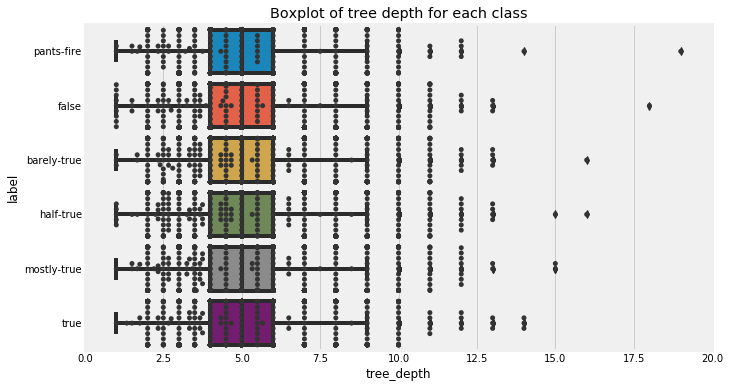

In [59]:
plt.figure(figsize=(10,6))
sns.boxplot(x='tree_depth', y='label', data=news_train, order=order_of_labels)
sns.swarmplot(x='tree_depth', y='label', data=news_train, color=".2", order=order_of_labels)
plt.title('Boxplot of tree depth for each class')

plt.show()

In [53]:
# find the sentiment for each statement using VADER
analyzer = SentimentIntensityAnalyzer()
news_train['vader_neg'] = 0
news_train['vader_pos'] = 0
news_train['vader_neu'] = 0
news_train['vader_compound'] = 0

for i, s in enumerate(news_train.statement):
    vs = analyzer.polarity_scores(s)
    news_train.iloc[i, -4] = vs['neg']
    news_train.iloc[i, -3] = vs['pos']
    news_train.iloc[i, -2] = vs['neu']
    news_train.iloc[i, -1] = vs['compound']

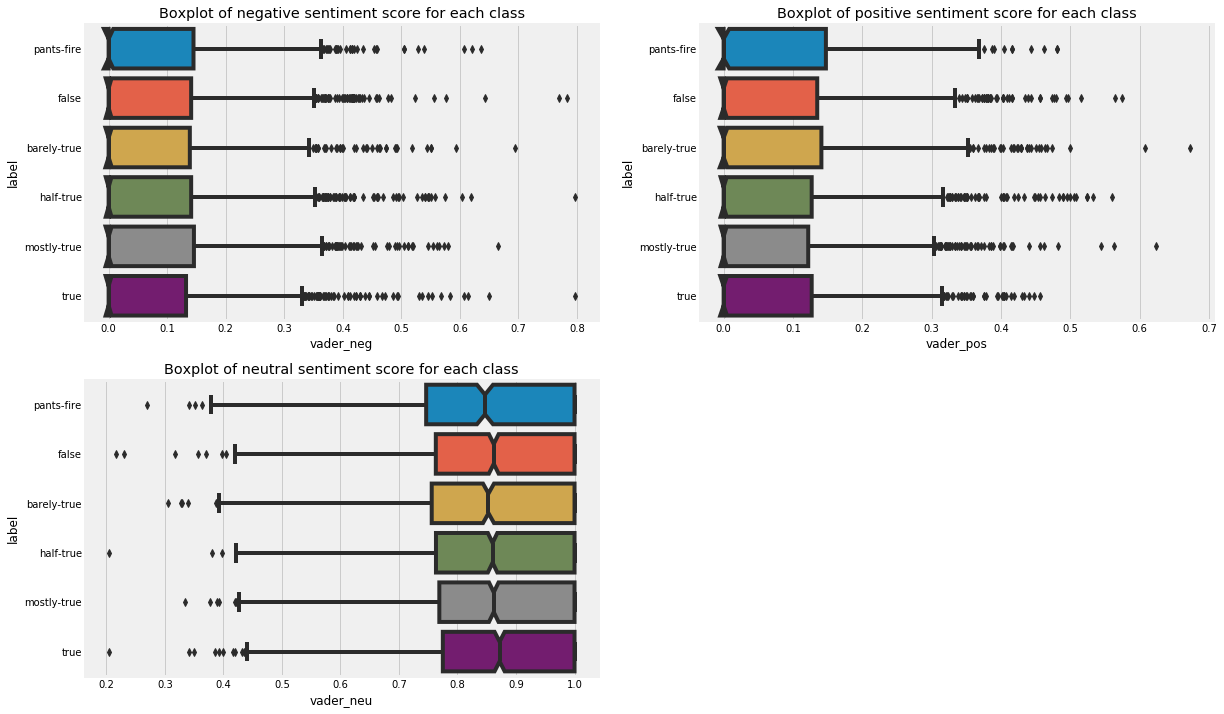

In [68]:
plt.figure(figsize=(18,12))
plt.subplot(221)
sns.boxplot(x='vader_neg', y='label', data=news_train, notch=True, order=order_of_labels)
plt.title('Boxplot of negative sentiment score for each class')
plt.subplot(222)
sns.boxplot(x='vader_pos', y='label', data=news_train, notch=True, order=order_of_labels)
plt.title('Boxplot of positive sentiment score for each class')
plt.subplot(223)
sns.boxplot(x='vader_neu', y='label', data=news_train, notch=True, order=order_of_labels)
plt.title('Boxplot of neutral sentiment score for each class')
plt.show()

In [78]:
for subj in unique_subjects:
    news_train['subj_' + subj] = 0

In [84]:
# dummify the subjects column
for i, subj in enumerate(news_train.subjects):
    subjects = subj.split(',')
    for subject in subjects:
        news_train.loc[i, 'subj_'+subject] = 1

In [101]:
subject_cols = [col for col in news_train.columns if col.startswith('subj_')]
subjects_count = news_train.groupby('label').sum()[subject_cols]

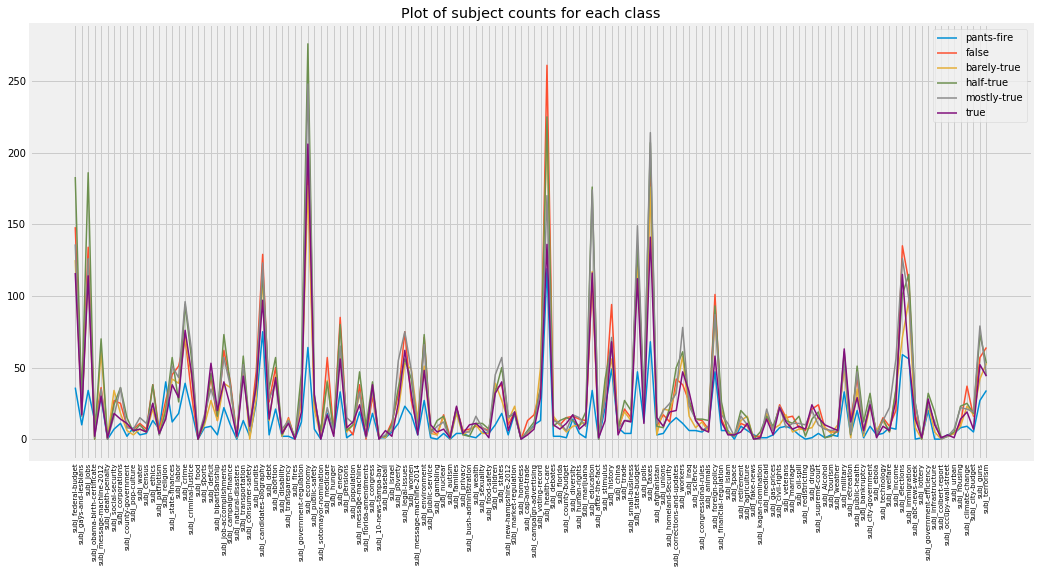

In [111]:
plt.figure(figsize=(16,8))
for lab in order_of_labels:
    plt.plot(subject_cols, subjects_count.loc[lab, :], label=lab, linewidth=1.5)
plt.legend()
plt.title('Plot of subject counts for each class')
plt.xticks(fontsize=7, rotation=90)
plt.show()

In [136]:
def calc_proportion(row):
    return row / np.sum(row)

In [137]:
subjects_proportion = subjects_count.apply(calc_proportion,axis=1)

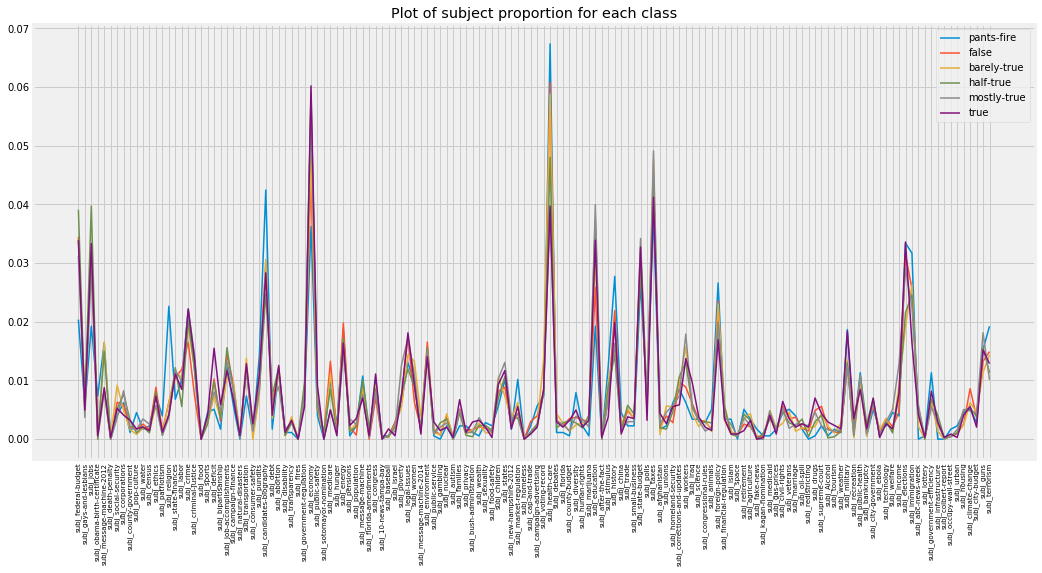

In [139]:
plt.figure(figsize=(16,8))
for lab in order_of_labels:
    plt.plot(subject_cols, subjects_proportion.loc[lab, :], label=lab, linewidth=1.5)
plt.legend()
plt.title('Plot of subject proportion for each class')
plt.xticks(fontsize=7, rotation=90)
plt.show()

## need to drop one column?

In [116]:
# dummify the party affliation column
news_train = pd.concat([news_train, pd.get_dummies(news_train.party, prefix='party')], axis=1)

In [117]:
party_cols = [col for col in news_train.columns if col.startswith('party_')]
party_count = news_train.groupby('label').sum()[party_cols]

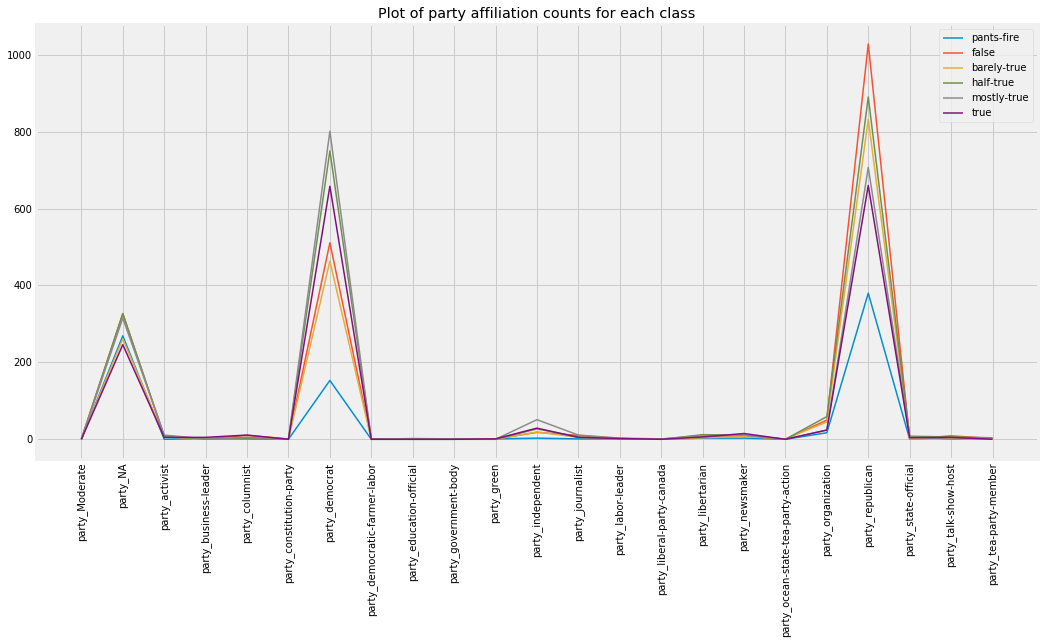

In [122]:
plt.figure(figsize=(16,8))
for lab in order_of_labels:
    plt.plot(party_cols, party_count.loc[lab, :], label=lab, linewidth=1.5)
plt.legend()
plt.title('Plot of party affiliation counts for each class')
plt.xticks(fontsize=10, rotation=90)
plt.show()

In [140]:
party_proportion = party_count.apply(calc_proportion,axis=1)

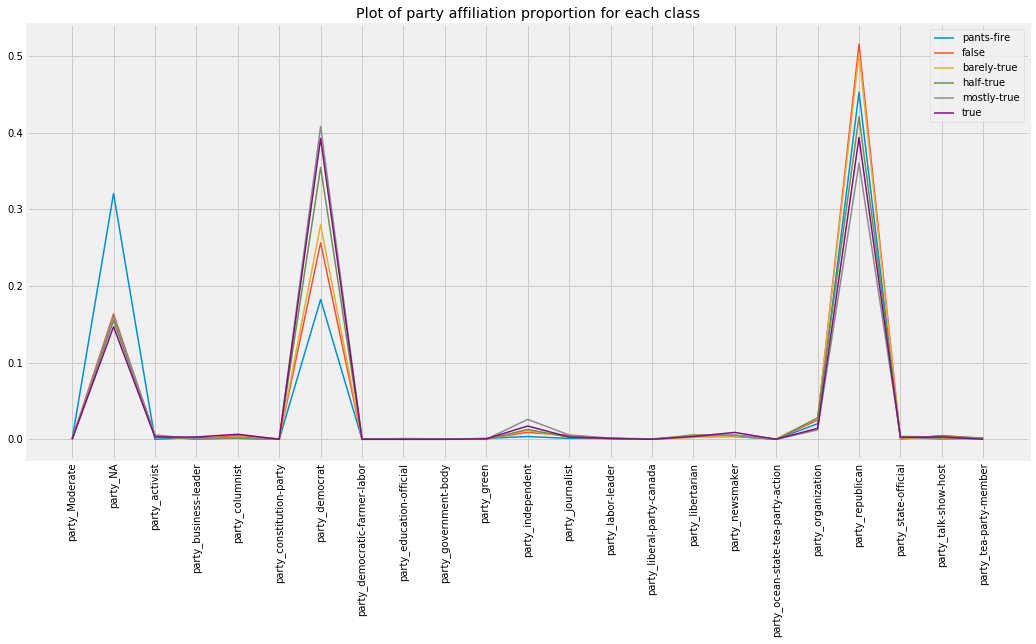

In [142]:
plt.figure(figsize=(16,8))
for lab in order_of_labels:
    plt.plot(party_cols, party_proportion.loc[lab, :], label=lab, linewidth=1.5)
plt.legend()
plt.title('Plot of party affiliation proportion for each class')
plt.xticks(fontsize=10, rotation=90)
plt.show()

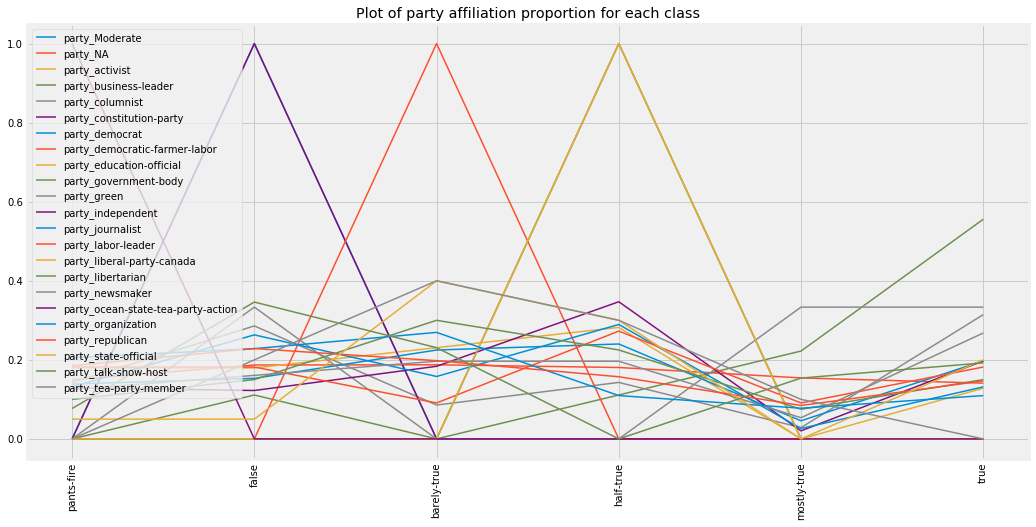

In [144]:
party_proportion2 = party_count.apply(calc_proportion,axis=0)
plt.figure(figsize=(16,8))
for party in party_cols:
    plt.plot(order_of_labels, party_proportion2[party], label=party, linewidth=1.5)
plt.legend()
plt.title('Plot of party affiliation proportion for each class')
plt.xticks(fontsize=10, rotation=90)
plt.show()

## need to drop one column

In [147]:
# dummify the state column
news_train = pd.concat([news_train, pd.get_dummies(news_train.state, prefix='state')], axis=1)

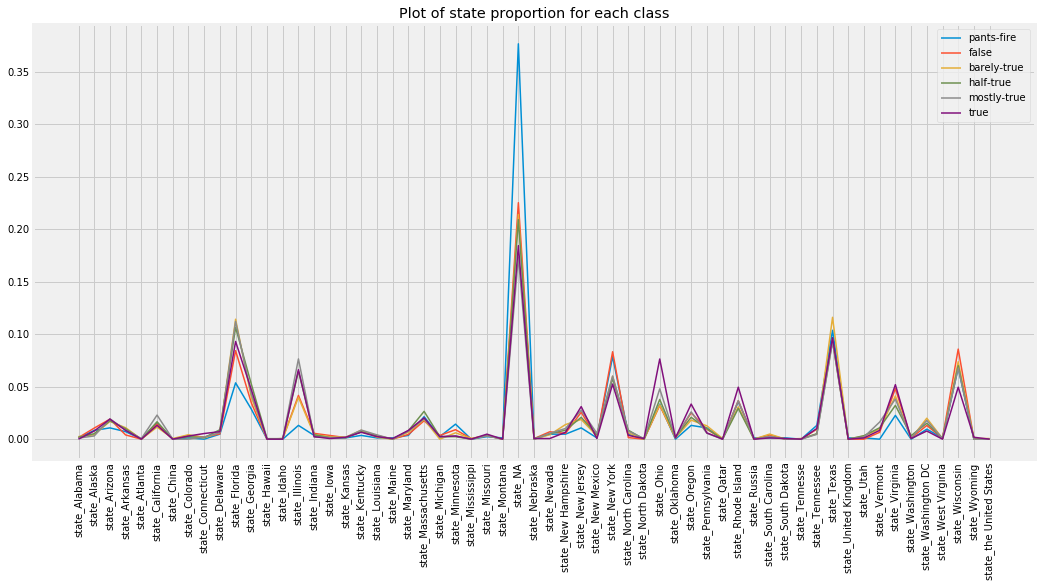

In [149]:
state_cols = [col for col in news_train.columns if col.startswith('state_')]
state_count = news_train.groupby('label').sum()[state_cols]
state_proportion = state_count.apply(calc_proportion,axis=1)
plt.figure(figsize=(16,8))
for lab in order_of_labels:
    plt.plot(state_cols, state_proportion.loc[lab, :], label=lab, linewidth=1.5)
plt.legend()
plt.title('Plot of state proportion for each class')
plt.xticks(fontsize=10, rotation=90)
plt.show()

In [195]:
top_speakers = news_train.speaker.value_counts()[0:10]
speaker_label_list = []
for speaker in top_speakers.index:
    speaker_label_list.append(news_train.loc[news_train.speaker == speaker]['label'].value_counts().to_dict())
speaker_label_count = pd.DataFrame(speaker_label_list)
speaker_label_proportion = speaker_label_count.apply(calc_proportion,axis=1)

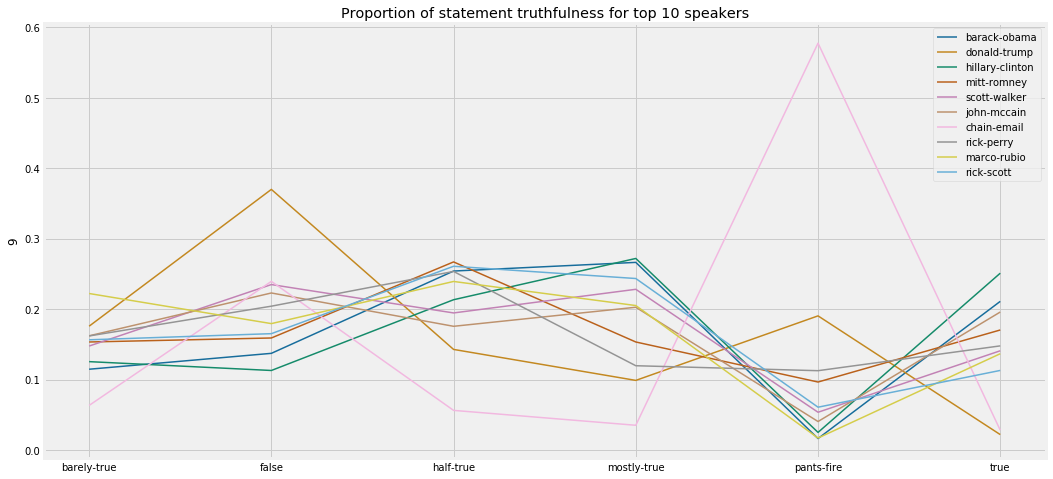

In [299]:
plt.figure(figsize=(16,8))
for i, speaker in enumerate(top_speakers.index):
    sns.lineplot(speaker_label_proportion.columns, speaker_label_proportion.loc[i, :], label=speaker, linewidth=1.5)
plt.legend()
plt.title('Proportion of statement truthfulness for top 10 speakers')
plt.xticks(fontsize=10, rotation=0)
plt.show()

In [177]:
news_train[news_train.label == 'pants-fire']['speaker'].value_counts()

chain-email                                    82
donald-trump                                   52
blog-posting                                   31
facebook-posts                                 26
mitt-romney                                    17
rick-perry                                     16
viral-image                                    11
michele-bachmann                               11
rush-limbaugh                                  10
newt-gingrich                                  10
barack-obama                                    8
scott-walker                                    8
rick-scott                                      7
democratic-congressional-campaign-committee     7
national-republican-congressional-committee     7
sarah-palin                                     6
hillary-clinton                                 6
john-mccain                                     6
ted-cruz                                        6
chris-christie                                  5


In [34]:
stopword_list = stopwords.words('english')

# remove negation terms
stopword_list.remove('no')
stopword_list.remove('not')

In [222]:
cvt = CountVectorizer(stop_words=stopword_list, ngram_range=(1,1))
counts = cvt.fit_transform(news_train['statement'])

In [224]:
statement_counts = pd.DataFrame(counts.toarray(), columns=cvt.get_feature_names())
statement_counts['label'] = news_train['label']

In [225]:
statement_counts.shape

(10238, 12060)

In [227]:
def plot_freq_words(word_counts):
    word_counts_grouped = word_counts.groupby('label').sum().T
    false_counts = word_counts_grouped['false'].sort_values(ascending=False)
    true_counts = word_counts_grouped['true'].sort_values(ascending=False)
    plt.figure(figsize=(16,8))
    plt.subplot(121)
    sns.barplot(x=false_counts.values[0:20], y=false_counts.index[0:20])
    plt.title("False statements")
    plt.xlabel('frequency')
    plt.subplot(122)
    sns.barplot(x=true_counts.values[0:20], y=true_counts.index[0:20])
    plt.title("True statements")
    plt.xlabel('frequency')
    plt.show()

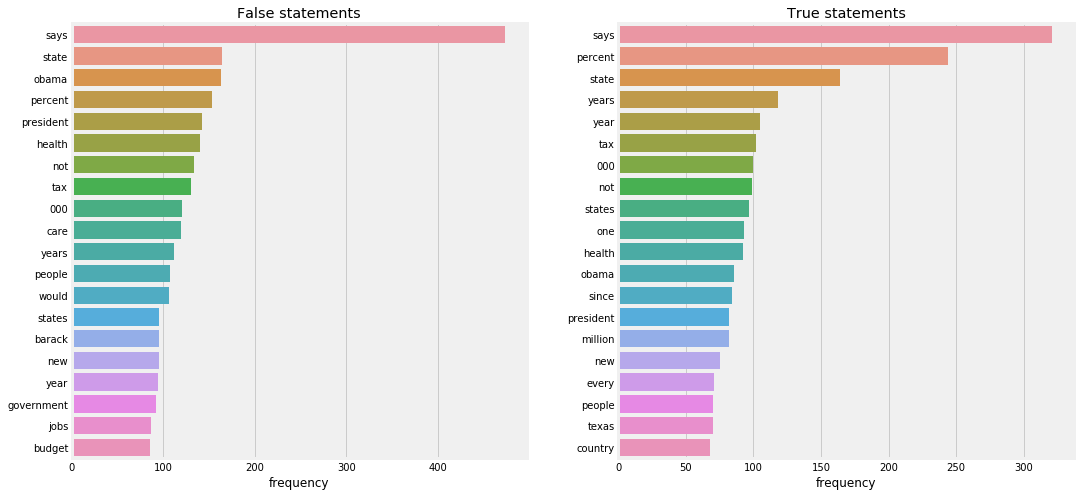

In [228]:
plot_freq_words(statement_counts)

In [230]:
cvt = CountVectorizer(stop_words=stopword_list, ngram_range=(2,2))
counts = cvt.fit_transform(news_train['statement'])

(10238, 74278)


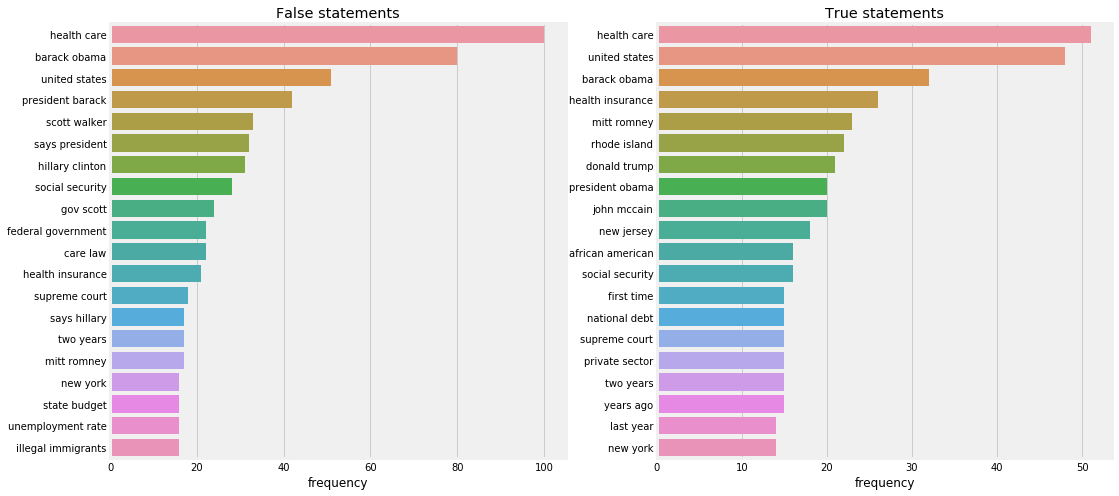

In [232]:
statement_counts = pd.DataFrame(counts.toarray(), columns=cvt.get_feature_names())
print (statement_counts.shape)
statement_counts['label'] = news_train['label']
plot_freq_words(statement_counts)

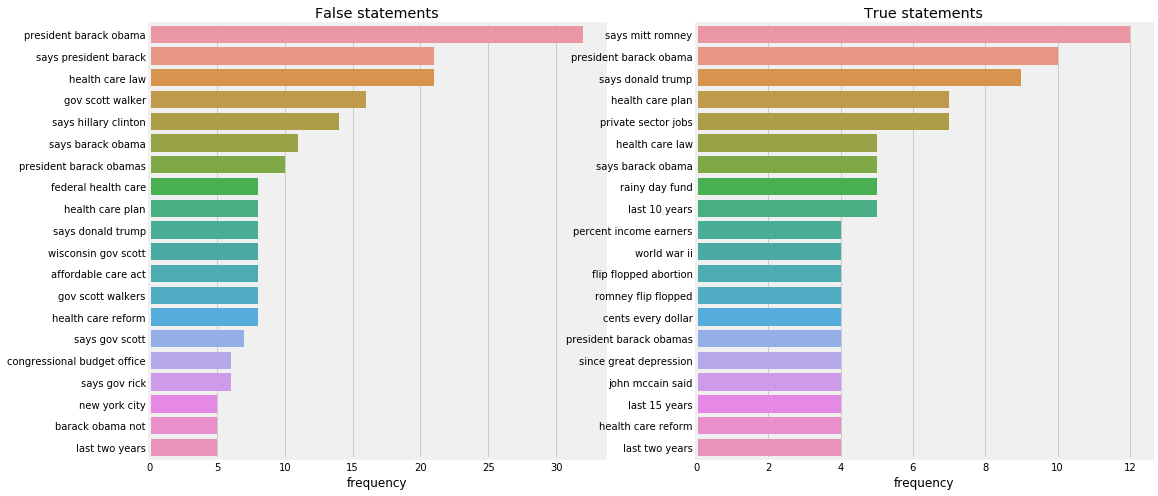

In [234]:
cvt = CountVectorizer(stop_words=stopword_list, ngram_range=(3,3))
counts = cvt.fit_transform(news_train['statement'])
statement_counts = pd.DataFrame(counts.toarray(), columns=cvt.get_feature_names())
statement_counts['label'] = news_train['label']
plot_freq_words(statement_counts)

**Modeling using statement as the only feature**

In [64]:
def train_validate(pipeline, X_train, y_train, X_valid, y_valid):
    try:
        pipeline.fit(X_train, y_train)
        return pipeline.score(X_valid, y_valid)
    except ValueError:
        return

In [180]:
def best_params(model_list):
    '''
        Function that returns the best parameters for the model with best mean score
    '''
    sorted_list = sorted(model_list, key=lambda k: -k['score']) 
    return sorted_list[0]

In [191]:
def grid_search(model, param_grid, X_train, y_train, X_valid, y_valid, X_test, y_test, is_pipeline=True, verbose=True):
    '''
        Function to search through models with different parameters
        
        Paramters
        ----------
        model: Object. Can be a pipeline or callable
        param_grid: dictionary of parameter values
        X_train: DataFrame
            Training design matrix 
        y_train: Series
            Training dataset labels
        X_valid: DataFrame
            Validation design matrix 
        y_valid: Series
            Valiation dataset labels
        X_test: DataFrame
            Test design matrix 
        y_test: Series
            Test dataset labels
        verbose: boolean, False by default
            If True, print progress of the training
    '''
    # create combinations
    param_names, values = zip(*param_grid.items())
    combinations = itertools.product(*values)
    
    num_combinations = 1
    for v in values:
        num_combinations *= len(v)
    
    results = []
    start = time.time()
    for index, params in enumerate(combinations):
        
        # run model
        model_params = dict(zip(param_names, params))
        if is_pipeline:
            model.set_params(**model_params)
            score = train_validate(model, X_train, y_train, X_valid, y_valid)
        
        # save validation score
        if score:
            results.append({'params': model_params, 'score': score})
        
        if (verbose) & (index%10 == 9):
            print (f"Done {index+1} out of {num_combinations} in {np.round((time.time()-start)/60, 2)} min")
    
    params = best_params(results)
    print ('-'*40)
    print ('Validation score:', params['score'])
    model.set_params(**params['params'])
    test_score = train_validate(model, X_train, y_train, X_test, y_test)
    print ('Test score:', test_score)  
    print ('Best parameters:', params['params'])
    
    return results

In [185]:
# logistic regression with count vectorizer
pipeline_text_logr = Pipeline([
    ('vect', CountVectorizer(stop_words=stopword_list, ngram_range=(2,3))),
    ('logr', LogisticRegression(multi_class='ovr', solver='liblinear', random_state=42))
])
params_text_logr = {'logr__C':np.logspace(3,4,10), 'logr__penalty': ['l1', 'l2']}
text_cvt_logr_results = grid_search(pipeline_text_logr, params_text_logr, news_train['statement'], news_train['label'], 
            news_valid['statement'], news_valid['label'], news_test['statement'], news_test['label'])


Done 10 out of 20 in 0.7 min
Done 20 out of 20 in 1.33 min
----------------------------------------
Validation score: 0.26246105919003115
Test score: 0.2249408050513023


In [194]:
# logistic regression with count vectorizer ngram 1,2
pipeline_text_logr = Pipeline([
    ('vect', CountVectorizer(stop_words=stopword_list, ngram_range=(1,2))),
    ('logr', LogisticRegression(multi_class='ovr', solver='liblinear', random_state=42))
])
params_text_logr = {'logr__C':np.logspace(-3,-1,10), 'logr__penalty': ['l1', 'l2']}
text_cvt_ngram12_logr_results = grid_search(pipeline_text_logr, params_text_logr, news_train['statement'], news_train['label'], 
            news_valid['statement'], news_valid['label'], news_test['statement'], news_test['label'])


Done 10 out of 20 in 0.16 min
Done 20 out of 20 in 0.37 min
----------------------------------------
Validation score: 0.2616822429906542
Test score: 0.250197316495659
Best parameters: {'logr__C': 0.021544346900318832, 'logr__penalty': 'l2'}


In [186]:
# logistic regression with tfidf
pipeline_text_logr = Pipeline([
    ('vect', TfidfVectorizer(stop_words=stopword_list, ngram_range=(2,3))),
    ('logr', LogisticRegression(multi_class='ovr', solver='liblinear', random_state=42))
])
params_text_logr = {'logr__C':np.logspace(3,4,10), 'logr__penalty': ['l1', 'l2']}
text_tfidf_logr_results = grid_search(pipeline_text_logr, params_text_logr, news_train['statement'], news_train['label'], 
            news_valid['statement'], news_valid['label'], news_test['statement'], news_test['label'])


/Users/joshuamei/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/joshuamei/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Done 10 out of 20 in 6.05 min
Done 20 out of 20 in 6.74 min
----------------------------------------
Validation score: 0.2554517133956386
Test score: 0.23599052880820837


In [195]:
# logistic regression with tfidf ngram 1,2
pipeline_text_logr = Pipeline([
    ('vect', TfidfVectorizer(stop_words=stopword_list, ngram_range=(1,2))),
    ('logr', LogisticRegression(multi_class='ovr', solver='liblinear', random_state=42))
])
params_text_logr = {'logr__C':np.logspace(-2,3,10), 'logr__penalty': ['l1', 'l2']}
text_tfidf_ngram12_logr_results = grid_search(pipeline_text_logr, params_text_logr, news_train['statement'], news_train['label'], 
            news_valid['statement'], news_valid['label'], news_test['statement'], news_test['label'])


Done 10 out of 20 in 0.19 min


/Users/joshuamei/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/joshuamei/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Done 20 out of 20 in 3.35 min
----------------------------------------
Validation score: 0.2523364485981308
Test score: 0.24388318863456984
Best parameters: {'logr__C': 5.994842503189409, 'logr__penalty': 'l2'}


In [188]:
# logistic regression with count vectorizer min_df=2
pipeline_text_logr = Pipeline([
    ('vect', CountVectorizer(stop_words=stopword_list, ngram_range=(2,3), min_df=2)),
    ('logr', LogisticRegression(multi_class='ovr', solver='liblinear', random_state=42))
])
params_text_logr = {'logr__C':np.logspace(3,4,10), 'logr__penalty': ['l1', 'l2']}
text_cvt2_logr_results = grid_search(pipeline_text_logr, params_text_logr, news_train['statement'], news_train['label'], 
            news_valid['statement'], news_valid['label'], news_test['statement'], news_test['label'])


/Users/joshuamei/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/joshuamei/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/joshuamei/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/joshuamei/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Done 10 out of 20 in 0.45 min


/Users/joshuamei/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/joshuamei/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/joshuamei/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/joshuamei/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/joshuamei/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increa

Done 20 out of 20 in 0.94 min
----------------------------------------
Validation score: 0.21806853582554517
Test score: 0.2170481452249408
Best parameters: {'logr__C': 1000.0, 'logr__penalty': 'l2'}


/Users/joshuamei/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [189]:
# logistic regression with count vectorizer and selectkbest
pipeline_text_logr = Pipeline([
    ('vect', CountVectorizer(stop_words=stopword_list, ngram_range=(2,3))),
    ('select', SelectKBest(k=20000)),
    ('logr', LogisticRegression(multi_class='ovr', solver='liblinear', random_state=42))
])
params_text_logr = {'logr__C':np.logspace(2,4,10), 'logr__penalty': ['l1', 'l2']}
text_cvt_kbest_logr_results = grid_search(pipeline_text_logr, params_text_logr, news_train['statement'], news_train['label'], 
            news_valid['statement'], news_valid['label'], news_test['statement'], news_test['label'])


Done 10 out of 20 in 0.39 min


/Users/joshuamei/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/joshuamei/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Done 20 out of 20 in 0.91 min
----------------------------------------
Validation score: 0.235202492211838
Test score: 0.2154696132596685
Best parameters: {'logr__C': 464.15888336127773, 'logr__penalty': 'l1'}


In [190]:
# SVM with linear kernel
pipeline_text_svm = Pipeline([
    ('vect', CountVectorizer(stop_words=stopword_list, ngram_range=(2,3))),
    ('svm', LinearSVC(random_state=42))
])
params_text_svm = {'svm__C':np.logspace(-2,3,10), 'svm__penalty': ['l1', 'l2'], 'svm__loss':['hinge', 'squared_hinge']}
text_svm_results = grid_search(pipeline_text_svm, params_text_svm, news_train['statement'], news_train['label'], 
            news_valid['statement'], news_valid['label'], news_test['statement'], news_test['label'])



Done 10 out of 40 in 0.18 min


/Users/joshuamei/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Done 20 out of 40 in 0.61 min


/Users/joshuamei/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/joshuamei/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Done 30 out of 40 in 1.43 min


/Users/joshuamei/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/joshuamei/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/joshuamei/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/joshuamei/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/joshuamei/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increa

Done 40 out of 40 in 2.89 min
----------------------------------------
Validation score: 0.2546728971962617
Test score: 0.23835832675611682
Best parameters: {'svm__C': 5.994842503189409, 'svm__penalty': 'l2', 'svm__loss': 'squared_hinge'}


/Users/joshuamei/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [196]:
# SVM with linear kernel ngram 1,2
pipeline_text_svm = Pipeline([
    ('vect', CountVectorizer(stop_words=stopword_list, ngram_range=(1,2))),
    ('svm', LinearSVC(random_state=42))
])
params_text_svm = {'svm__C':np.logspace(-2,3,10), 'svm__penalty': ['l1', 'l2'], 'svm__loss':['hinge', 'squared_hinge']}
text_ngram12_svm_results = grid_search(pipeline_text_svm, params_text_svm, news_train['statement'], news_train['label'], 
            news_valid['statement'], news_valid['label'], news_test['statement'], news_test['label'])


Done 10 out of 40 in 0.16 min


/Users/joshuamei/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Done 20 out of 40 in 0.57 min


/Users/joshuamei/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/joshuamei/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/joshuamei/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Done 30 out of 40 in 1.16 min


/Users/joshuamei/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/joshuamei/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/joshuamei/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/joshuamei/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/joshuamei/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increa

Done 40 out of 40 in 2.16 min
----------------------------------------
Validation score: 0.2515576323987539
Test score: 0.24546172059984214
Best parameters: {'svm__C': 0.01, 'svm__penalty': 'l2', 'svm__loss': 'squared_hinge'}


In [192]:
# Multinomial Naive Bayes
pipeline_text_mnb = Pipeline([
    ('vect', CountVectorizer(stop_words=stopword_list, ngram_range=(2,3))),
    ('mnb', MultinomialNB())
])
valid_score = train_validate(pipeline_text_mnb, news_train['statement'], news_train['label'], 
            news_valid['statement'], news_valid['label'])
print ('Validation score:', valid_score)

test_score = train_validate(pipeline_text_mnb, news_train['statement'], news_train['label'], 
                            news_test['statement'], news_test['label'])
print ('Test score:', test_score)  


Validation score: 0.25
Test score: 0.2123125493291239


In [193]:
# Random Forest
pipeline_text_rfc = Pipeline([
    ('vect', CountVectorizer(stop_words=stopword_list, ngram_range=(2,3))),
    ('rfc', RandomForestClassifier(random_state=42))
])
params_text_rfc = {'rfc__n_estimators':np.arange(100,300,100), 'rfc__min_samples_split': np.arange(2,10,2)}
text_rfc_results = grid_search(pipeline_text_rfc, params_text_rfc, news_train['statement'], news_train['label'], 
            news_valid['statement'], news_valid['label'], news_test['statement'], news_test['label'])


----------------------------------------
Validation score: 0.235202492211838
Test score: 0.2280978689818469
Best parameters: {'rfc__n_estimators': 200, 'rfc__min_samples_split': 2}


**Modeling using statement (BOW, length, unique words, POS, parse tree depth, sentiment) and meta-data (speaker, party affiliation, state, context)**

In [139]:
class ItemSelector(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key

    def fit(self, x, y=None):
        return self

    def transform(self, data_dict):
        return data_dict[self.key]

In [140]:
class TextStats(BaseEstimator, TransformerMixin):
    def fit(self, x, y=None):
#         print ('fit text stats')
        return self

    def transform(self, statements):
#         print ('transform text stats')
        text_stats_features = []
        analyzer = SentimentIntensityAnalyzer()
        for text in statements:
            features_dict = {'statement_length': len(text.split()),
                     'unique_words': len(np.unique(text.split()))}
            # getting POS
            parsed = nlp(text)
            parsed_len = len(parsed)
            for pos in unique_pos:
                if pos != 'X':
                    count = len([token for token in parsed if token.pos_ == pos])
                    features_dict[pos + '_prop'] = float(count)/parsed_len
            
            # getting parse tree depth
            root_words = []
            for sentence in parsed.sents:
                root_words.append(sentence.root) # find the root word of each sentence
            depths = []
            for token in parsed:
                if token in root_words:
                    depths.append(get_depth(token)) # find the tree depth starting from the root word
            features_dict['tree_depth'] = np.mean(depths) # find the average tree depth
            
            # VADER sentiment
            vs = analyzer.polarity_scores(text)
            features_dict['vader_neg'] = vs['neg']
            features_dict['vader_pos'] = vs['pos']
            features_dict['vader_neu'] = vs['neu']
            features_dict['vader_compound'] = vs['compound']
            
            text_stats_features.append(features_dict)
        
        return text_stats_features

In [141]:
class Dummify(BaseEstimator, TransformerMixin):
    def __init__(self, multilabel=False):
        self.multilabel = multilabel
        self.ohe = OneHotEncoder(handle_unknown='ignore')
        self.mlb = MultiLabelBinarizer(sparse_output=True)
#         self.ohe = OneHotEncoder()
        
    def fit(self, x, y=None):
#         print ('fit non text')
        if self.multilabel:
            subjects = [set(value.split(',')) for value in x]
            self.mlb.fit(subjects)
        else:
            self.ohe.fit(x.to_frame())
        return self

    def transform(self, x):
#         print ('transform non text')
        if self.multilabel:
            subjects = [set(value.split(',')) for value in x]
            return self.mlb.transform(subjects)
        else:
            transformed_x = self.ohe.transform(x.to_frame())
            return transformed_x[:,1:] # drop first column
    
    def get_feature_names(self, input_features=None):
        if self.multilabel:
            return self.mlb.classes_
        return self.ohe.get_feature_names(input_features)[1:]

In [142]:
transformer_pipeline = Pipeline([
    # Use FeatureUnion to combine the features from statement and meta data
    ('union', FeatureUnion(
        transformer_list=[

            # Pipeline for get BOW from statement
            ('text_vect', Pipeline([
                ('selector', ItemSelector(key='statement')),
                ('cvt', CountVectorizer(stop_words=stopword_list, ngram_range=(2,3))),
#                 ('best', TruncatedSVD(n_components=50)),
            ])),

            # Pipeline for get text statistics from statement
            ('text_stats', Pipeline([
                ('selector', ItemSelector(key='statement')),
                ('stats', TextStats()),  # returns a list of dicts
                ('dict_vect', DictVectorizer()),  # list of dicts -> feature matrix
            ])),
            
            # Pipeline to dummify party column
            ('party', Pipeline([
                ('selector', ItemSelector(key='party')),
                ('ohe', Dummify()),
            ])),
            
            # Pipeline to dummify context column
            ('context', Pipeline([
                ('selector', ItemSelector(key='context')),
                ('ohe', Dummify()),
            ])),
            
            # Pipeline to dummify state column
            ('state', Pipeline([
                ('selector', ItemSelector(key='state')),
                ('ohe', Dummify()),
            ])),
            
            # Pipeline to dummify speaker column
            ('speaker', Pipeline([
                ('selector', ItemSelector(key='speaker')),
                ('ohe', Dummify()),
            ])),
            
            # Pipeline to dummify subjects column
            ('subjects', Pipeline([
                ('selector', ItemSelector(key='subjects')),
                ('ohe', Dummify(multilabel=True)),
            ])),
            
            # Pipeline to dummify past credibility columns
            ('credibility', Pipeline([
                ('selector', ItemSelector(key=['pants_on_fire', 'false', 'barely_true', 'half_true', 'mostly_true'])),
            ])),

        ],
    )),
])


In [144]:
transformer_pipeline.fit(news_train)

Pipeline(memory=None,
     steps=[('union', FeatureUnion(n_jobs=None,
       transformer_list=[('text_vect', Pipeline(memory=None,
     steps=[('selector', ItemSelector(key='statement')), ('cvt', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max...ector', ItemSelector(key=['pants_on_fire', 'false', 'barely_true', 'half_true', 'mostly_true']))]))],
       transformer_weights=None))])

In [145]:
X_train = transformer_pipeline.transform(news_train)

In [146]:
X_valid = transformer_pipeline.transform(news_valid)

In [147]:
X_test = transformer_pipeline.transform(news_test)

/Users/joshuamei/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:935: UserWarning: unknown class(es) ['nightlife', 'politifacts-top-promises'] will be ignored
  .format(sorted(unknown, key=str)))


In [66]:
# logistic regression with all features
pipeline_all_logr = Pipeline([
    ('logr', LogisticRegression(multi_class='ovr', solver='liblinear', random_state=42))
])
params_all_logr = {'logr__C':np.logspace(-2,3,10), 'logr__penalty': ['l1', 'l2']}
all_logr_results = grid_search(pipeline_all_logr, params_all_logr, X_train, news_train['label'], 
            X_valid, news_valid['label'])
best_params(all_logr_results)

Done 10 out of 20 in 7.59 min


/Users/joshuamei/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Done 20 out of 20 in 29.21 min


{'params': {'logr__C': 0.464158883361278, 'logr__penalty': 'l1'},
 'score': 0.37538940809968846}

In [67]:
# TEST logistic regression with all features
pipeline_all_logr = Pipeline([
    ('logr', LogisticRegression(multi_class='ovr', solver='liblinear', random_state=42))
])
params_all_logr = {'logr__C':[0.464158883361278], 'logr__penalty': ['l1']}
all_logr_results_test = grid_search(pipeline_all_logr, params_all_logr, X_train, news_train['label'], 
            X_test, news_test['label'])
best_params(all_logr_results_test)


{'params': {'logr__C': 0.464158883361278, 'logr__penalty': 'l1'},
 'score': 0.34490923441199683}

In [69]:
# SVM with linear kernel
pipeline_all_svm = Pipeline([
    ('svm', LinearSVC(random_state=42))
])
params_all_svm = {'svm__C':np.logspace(-2,3,10), 'svm__penalty': ['l1', 'l2'], 'svm__loss':['hinge', 'squared_hinge']}
all_svm_results = grid_search(pipeline_all_svm, params_all_svm, X_train, news_train['label'], 
            X_valid, news_valid['label'])
best_params(all_svm_results)


/Users/joshuamei/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/joshuamei/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/joshuamei/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/joshuamei/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Done 10 out of 40 in 1.47 min


/Users/joshuamei/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/joshuamei/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/joshuamei/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/joshuamei/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/joshuamei/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increa

Done 20 out of 40 in 3.86 min


/Users/joshuamei/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/joshuamei/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/joshuamei/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/joshuamei/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Done 30 out of 40 in 5.58 min


/Users/joshuamei/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/joshuamei/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/joshuamei/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/joshuamei/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/joshuamei/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increa

Done 40 out of 40 in 8.17 min


/Users/joshuamei/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


{'params': {'svm__C': 0.001, 'svm__penalty': 'l2', 'svm__loss': 'hinge'},
 'score': 0.32710280373831774}

In [70]:
# TEST SVM with linear kernel
pipeline_all_svm = Pipeline([
    ('svm', LinearSVC(random_state=42))
])
params_all_svm = {'svm__C':[0.01], 'svm__penalty': ['l2'], 'svm__loss':['squared_hinge']}
all_svm_results = grid_search(pipeline_all_svm, params_all_svm, X_train, news_train['label'], 
            X_test, news_test['label'])
best_params(all_svm_results)


/Users/joshuamei/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


{'params': {'svm__C': 0.01,
  'svm__penalty': 'l2',
  'svm__loss': 'squared_hinge'},
 'score': 0.3007103393843725}

**Multilayer perceptron**

**Examine coefficients**

In [77]:
pipeline_text_logr_final = Pipeline([
    ('vect', CountVectorizer(stop_words=stopword_list, ngram_range=(1,2))),
    ('logr', LogisticRegression(multi_class='ovr', solver='liblinear', random_state=42, C=0.021544346900318832,
                               penalty='l2'))
])
pipeline_text_logr_final.fit(news_train['statement'], news_train['label'])

Pipeline(memory=None,
     steps=[('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 2), preprocessor=None,
        stop_words=['i', 'me',...alty='l2', random_state=42,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False))])

In [81]:
pipeline_text_logr_final.named_steps['logr'].classes_

array(['barely-true', 'false', 'half-true', 'mostly-true', 'pants-fire',
       'true'], dtype=object)

In [94]:
text_coef = pd.DataFrame(pipeline_text_logr_final.named_steps['logr'].coef_).T
text_coef.columns = pipeline_text_logr_final.named_steps['logr'].classes_
text_coef['ngram'] = pipeline_text_logr_final.named_steps['vect'].get_feature_names()
text_coef.sort_values('pants-fire', ascending=False)

,barely-true,false,half-true,mostly-true,pants-fire,true,ngram
109588,0.000000,-5.360077,-0.870131,-0.390828,14.879261,0.000000,president obama muslim
36887,-3.993340,-8.546740,-6.426387,-6.205952,14.168548,-6.119189,crime rising
124990,0.000000,-3.157961,0.000000,0.000000,13.588175,-0.961210,says first governor
9475,-4.207547,-2.298490,-5.005325,-4.763888,10.486928,-2.341506,admits not
94128,-2.050204,0.000000,0.000000,0.000000,10.159078,-1.483189,not even american
155088,-1.371090,-4.027756,-1.334445,-0.138467,9.908938,0.000000,warming hoax
118913,-0.783803,-4.009904,-1.301113,-2.274181,9.795167,-1.526801,republicans wisconsin
157659,-0.192621,-5.308949,-0.280353,0.000000,9.718808,-0.081993,wisconsin unemployments
47763,0.000000,-1.961201,-4.311924,0.000000,9.267387,-0.294685,endorse federal stimulus
102498,0.000000,1.369504,0.000000,0.000000,9.123874,0.000000,pay taxes 10


In [91]:
text_coef.sort_values('true', ascending=False)

,barely-true,false,half-true,mostly-true,pants-fire,true,ngram
46353,-0.032025,-0.105505,-0.095558,-0.018433,-0.107436,0.257506,mccain
31928,-0.043909,-0.221682,0.027096,0.010442,-0.150287,0.232571,georgia
29409,-0.049913,-0.036301,-0.119858,-0.030061,-0.122553,0.222748,first
70252,-0.166845,-0.264865,0.063508,0.113937,-0.198970,0.201449,since
77458,-0.098034,-0.121057,-0.040984,0.063288,-0.134419,0.187878,three
6288,-0.072843,-0.230952,0.048414,-0.001815,-0.056175,0.179395,american
20773,-0.110975,-0.217817,0.006243,0.098884,-0.047079,0.168051,day
34560,-0.092490,-0.119736,-0.114800,0.186853,-0.139914,0.166471,half
37754,-0.054055,0.016525,-0.047369,-0.068411,-0.084854,0.162121,income
49525,-0.042339,-0.153863,-0.005818,-0.011139,-0.016683,0.160825,nearly


In [92]:
# ngrams 2,3
pipeline_text_logr_final = Pipeline([
    ('vect', CountVectorizer(stop_words=stopword_list, ngram_range=(2,3))),
    ('logr', LogisticRegression(multi_class='ovr', solver='liblinear', random_state=42, C=5994.8425031894085,
                               penalty='l1'))
])
pipeline_text_logr_final.fit(news_train['statement'], news_train['label'])

Pipeline(memory=None,
     steps=[('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(2, 3), preprocessor=None,
        stop_words=['i', 'me',...alty='l1', random_state=42,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False))])

In [95]:
text_coef = pd.DataFrame(pipeline_text_logr_final.named_steps['logr'].coef_).T
text_coef.columns = pipeline_text_logr_final.named_steps['logr'].classes_
text_coef['ngram'] = pipeline_text_logr_final.named_steps['vect'].get_feature_names()
text_coef.sort_values('pants-fire', ascending=False)

,barely-true,false,half-true,mostly-true,pants-fire,true,ngram
109588,0.000000,-5.360077,-0.870131,-0.390828,14.879261,0.000000,president obama muslim
36887,-3.993340,-8.546740,-6.426387,-6.205952,14.168548,-6.119189,crime rising
124990,0.000000,-3.157961,0.000000,0.000000,13.588175,-0.961210,says first governor
9475,-4.207547,-2.298490,-5.005325,-4.763888,10.486928,-2.341506,admits not
94128,-2.050204,0.000000,0.000000,0.000000,10.159078,-1.483189,not even american
155088,-1.371090,-4.027756,-1.334445,-0.138467,9.908938,0.000000,warming hoax
118913,-0.783803,-4.009904,-1.301113,-2.274181,9.795167,-1.526801,republicans wisconsin
157659,-0.192621,-5.308949,-0.280353,0.000000,9.718808,-0.081993,wisconsin unemployments
47763,0.000000,-1.961201,-4.311924,0.000000,9.267387,-0.294685,endorse federal stimulus
102498,0.000000,1.369504,0.000000,0.000000,9.123874,0.000000,pay taxes 10


In [96]:
text_coef.sort_values('true', ascending=False)

,barely-true,false,half-true,mostly-true,pants-fire,true,ngram
51990,-3.783867,-8.724030,-7.136376,-6.135230,-2.408018,11.208686,farouk fire
143455,-3.871348,-8.713761,-7.136374,-6.135186,-2.407878,11.199548,texans millionaires
36805,-3.871008,-8.713855,-7.136363,-6.177780,-2.354440,11.175853,crime arizona
114773,0.000000,0.000000,0.000000,-10.829665,0.000000,10.574424,rate world 35
43768,0.000000,0.000000,0.000000,0.000000,0.000000,9.821994,donald trump supported
44597,0.000000,-0.022775,-8.232257,-0.141007,0.000000,9.364402,drilling energy
128837,0.000000,0.000000,0.000000,-1.146432,0.000000,9.174254,sen obama iraq
129188,0.000000,0.000000,0.000000,-0.713442,0.000000,9.099932,senator mccain voted
93401,0.000000,-0.396253,0.000000,0.000000,0.000000,8.852063,no state tuition
83791,-0.184166,-2.485158,-3.696562,-1.242384,0.000000,8.688309,mandatory ultrasounds abortions


In [97]:
text_coef.sort_values('half-true', ascending=False)

,barely-true,false,half-true,mostly-true,pants-fire,true,ngram
17478,-1.244649,-4.483910,11.147173,0.000000,0.000000,-0.909112,barack obamas stimulus
13619,-3.650383,-8.713889,10.252115,-6.135740,-2.354472,-6.149735,answer hypotheticals
113117,-3.770303,-8.724162,10.252115,-6.204751,-2.408161,-6.153218,put emails
147934,-3.870989,-8.723890,10.227306,-6.177780,-2.354445,-6.182898,transportation financing
63234,-3.650011,-8.724111,10.227306,-6.134988,-2.407878,-6.182493,gun policy
60303,-3.553495,-4.698997,10.177760,-2.279339,-1.410554,-2.958606,going cut
96024,0.000000,-1.420028,9.804694,0.000000,0.000000,0.000000,obama position gay
22295,-1.686739,0.000000,9.529318,0.000000,0.000000,0.000000,buck wants privatize
19276,-3.262732,-5.194979,9.318915,-3.780615,-1.074218,-2.235512,bill ban
151243,0.000000,-3.337149,9.258837,-0.485783,0.000000,-4.382629,usa gun violence


In [148]:
X_train.shape

(10238, 169891)

In [149]:
# TEST logistic regression with all features
pipeline_all_logr = Pipeline([
    ('logr', LogisticRegression(multi_class='ovr', solver='liblinear', random_state=42, C=0.464158883361278,
                               penalty='l1'))
])
pipeline_all_logr.fit(X_train, news_train['label'])

Pipeline(memory=None,
     steps=[('logr', LogisticRegression(C=0.464158883361278, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=None, penalty='l1', random_state=42,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False))])

In [153]:
ngrams = dict(transformer_pipeline.named_steps['union'].transformer_list).get('text_vect').named_steps['cvt'].get_feature_names()
text_stats = dict(transformer_pipeline.named_steps['union'].transformer_list).get('text_stats').named_steps['dict_vect'].get_feature_names()
party = dict(transformer_pipeline.named_steps['union'].transformer_list).get('party').named_steps['ohe'].get_feature_names(['party'])
context = dict(transformer_pipeline.named_steps['union'].transformer_list).get('context').named_steps['ohe'].get_feature_names(['context'])
state = dict(transformer_pipeline.named_steps['union'].transformer_list).get('state').named_steps['ohe'].get_feature_names(['state'])
speaker = dict(transformer_pipeline.named_steps['union'].transformer_list).get('speaker').named_steps['ohe'].get_feature_names(['speaker'])
subjects = 'subject_' + dict(transformer_pipeline.named_steps['union'].transformer_list).get('subjects').named_steps['ohe'].get_feature_names(['subjects'])
credibility = ['pants_on_fire', 'false', 'barely_true', 'half_true', 'mostly_true']

In [154]:
features = list(itertools.chain(ngrams, text_stats, party, context, state, speaker, subjects, credibility))

In [156]:
pd.DataFrame(pipeline_all_logr.named_steps['logr'].coef_)

,0,1,2,3,4,5,6,7,8,9,...,169881,169882,169883,169884,169885,169886,169887,169888,169889,169890
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.406363,-0.323998,0.335864,0.247493,0.012429,-0.178986,0.469100,-0.143614,-0.067998
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,-0.294818,-0.446075,-0.106963,0.317760,-0.149563,-0.056299,-0.015714
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.113351,0.000000,-0.380900,0.000000,0.000000,0.008068,-0.064197,-0.145252,0.413514,-0.275076
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.880356,0.000000,0.226170,0.009527,-0.037995,-0.052128,-0.233123,0.317087
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.166759,0.019156,-0.511347,0.173485,-0.068040,-0.032149,-0.001095,0.017518
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,-0.040568,0.000000,-0.017334,-0.007911,-0.012455,0.007722,0.005915


In [157]:
pipeline_all_logr.named_steps['logr'].classes_

array(['barely-true', 'false', 'half-true', 'mostly-true', 'pants-fire',
       'true'], dtype=object)

In [161]:
all_coef = pd.DataFrame(pipeline_all_logr.named_steps['logr'].coef_).T
all_coef.columns = pipeline_all_logr.named_steps['logr'].classes_
all_coef['features'] = features
all_coef.sort_values('pants-fire', ascending=False)
# all_coef

,barely-true,false,half-true,mostly-true,pants-fire,true,features
162398,0.000000,0.208031,-0.100359,-1.317809,1.847826,-1.274349,PROPN_prop
162402,0.561774,0.000000,0.000000,-1.245304,1.415462,-1.028593,VERB_prop
164062,0.000000,0.000000,0.000000,0.000000,1.299846,0.000000,context_a radio ad.
167016,13.380787,0.000000,-6.255518,-7.664782,1.279675,0.000000,speaker_barack-obama
4260,0.000000,0.000000,-0.384755,0.000000,1.093997,0.000000,250 000
124547,0.000000,0.000000,-0.528950,0.000000,1.018233,0.000000,says barack obama
36579,0.000000,0.000000,0.000000,0.000000,0.984162,0.000000,created zero
69186,0.000000,0.000000,0.000000,0.000000,0.943169,0.000000,inches away
127685,0.000000,0.000000,0.000000,0.000000,0.905570,0.000000,sean duffy
113906,0.000000,0.000000,0.000000,0.000000,0.848066,0.000000,raise taxes middle


In [159]:
all_coef.sort_values('true', ascending=False)

,barely-true,false,half-true,mostly-true,pants-fire,true,features
166878,0.000000,0.000000,0.000000,0.000000,0.000000,1.231760,speaker_alex-sink
142930,0.000000,0.000000,0.000000,0.000000,0.000000,1.176434,ten years
128832,0.000000,0.000000,0.000000,0.000000,0.000000,1.120433,sen obama
30401,0.000000,0.000000,0.000000,0.000000,0.000000,1.114527,co sponsored legislation
155142,0.000000,0.000000,0.000000,0.000000,0.000000,1.099459,warren buffett
7635,0.000000,0.000000,0.000000,0.000000,0.000000,1.059102,abraham lincoln
54679,0.000000,0.000000,0.000000,0.000000,0.000000,0.965870,flopped abortion
54098,0.000000,0.000000,0.000000,0.000000,0.000000,0.961662,first state
67445,-0.019484,0.000000,-0.195784,0.000000,0.000000,0.960726,house representatives
9948,0.000000,-0.607369,0.000000,-0.386586,0.000000,0.912327,african american


In [160]:
all_coef.sort_values('false', ascending=False)

,barely-true,false,half-true,mostly-true,pants-fire,true,features
91786,0.000000,1.923585,0.000000,0.000000,0.000000,0.000000,never asked
167946,1.127874,1.914563,0.000000,-4.446529,0.000000,0.287359,speaker_hillary-clinton
148685,0.000000,1.172508,0.000000,0.000000,0.000000,0.000000,true says
167262,-1.087906,1.123163,0.000000,0.000000,0.000000,0.000000,speaker_charlie-crist
59001,0.000000,1.052181,0.000000,0.000000,0.000000,0.000000,get jail
125441,0.000000,1.045111,0.000000,0.000000,0.000000,0.000000,says many
152235,0.000000,0.983362,0.000000,0.000000,0.000000,0.000000,vice president
154995,0.000000,0.959937,0.000000,0.000000,0.000000,0.000000,war iraq
64726,0.000000,0.911325,0.000000,0.000000,0.000000,0.000000,health reform
61854,0.000000,0.889047,0.000000,-0.217366,0.000000,0.000000,governor massachusetts


In [162]:
# TEST SVM with linear kernel
pipeline_all_svm = Pipeline([
    ('svm', LinearSVC(random_state=42, C=0.01, penalty='l2', loss='squared_hinge'))
])
pipeline_all_svm.fit(X_train, news_train['label'])

/Users/joshuamei/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Pipeline(memory=None,
     steps=[('svm', LinearSVC(C=0.01, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=42, tol=0.0001,
     verbose=0))])

In [164]:
pd.DataFrame(pipeline_all_svm.named_steps['svm'].coef_)

,0,1,2,3,4,5,6,7,8,9,...,169881,169882,169883,169884,169885,169886,169887,169888,169889,169890
0,-0.001216,-0.001216,-0.004606,-0.004606,-0.025335,-0.003320,-0.006849,-0.001694,-0.007016,-0.002702,...,0.012497,0.073254,-0.062636,0.094015,0.068471,0.001257,-0.019508,0.043828,-0.010858,-0.002881
1,-0.005094,-0.005094,-0.006357,-0.006357,0.024570,-0.006606,0.026617,-0.004819,0.020139,-0.005493,...,0.004631,-0.048512,-0.030056,-0.077847,-0.118439,-0.009415,0.026059,-0.026689,-0.001568,0.000680
2,-0.002027,-0.002027,-0.006265,-0.006265,-0.027846,-0.006413,-0.004549,-0.004998,-0.003650,-0.004268,...,-0.040284,-0.023584,-0.084784,-0.022986,-0.000792,-0.003746,-0.002028,-0.009849,0.039561,-0.031367
3,-0.000935,-0.000935,0.022691,0.022691,-0.018053,-0.006539,-0.006178,0.019024,-0.005670,-0.009531,...,0.016704,-0.005019,0.161859,0.012256,0.088625,-0.001212,0.002178,-0.004961,-0.028802,0.030211
4,0.009556,0.009556,-0.002254,-0.002254,-0.009522,-0.000499,-0.001686,-0.000108,-0.003094,-0.000955,...,-0.028720,-0.008440,0.046619,0.013998,-0.068740,0.014887,-0.006170,-0.001279,0.000980,0.000303
5,0.000000,0.000000,-0.007480,-0.007480,0.051205,0.023218,-0.007280,-0.006040,-0.003000,0.021797,...,0.032848,-0.013614,-0.032606,-0.024774,0.013227,-0.002805,-0.000051,-0.004193,0.001761,0.001148


In [170]:
pipeline_all_svm.named_steps['svm'].classes_

array(['barely-true', 'false', 'half-true', 'mostly-true', 'pants-fire',
       'true'], dtype=object)

In [171]:
all_coef = pd.DataFrame(pipeline_all_svm.named_steps['svm'].coef_).T
all_coef.columns = pipeline_all_svm.named_steps['svm'].classes_
all_coef['features'] = features
all_coef.sort_values('pants-fire', ascending=False)

,barely-true,false,half-true,mostly-true,pants-fire,true,features
162398,0.005102,0.078608,-0.052402,-0.280081,0.158424,-0.200533,PROPN_prop
169855,0.005499,-0.028086,-0.045962,-0.048343,0.152040,-0.057409,subject_religion
169657,-0.018587,0.020483,-0.049688,-0.045794,0.144590,-0.051482,speaker_viral-image
167106,0.000389,0.035889,-0.011552,-0.110423,0.129584,-0.042177,speaker_blog-posting
169839,-0.064845,0.032516,-0.062351,-0.027443,0.118763,-0.002896,subject_obama-birth-certificate
124547,-0.014616,0.010511,-0.085257,-0.042084,0.116606,0.012057,says barack obama
169265,0.019436,0.074246,-0.057112,-0.050310,0.107029,-0.087190,speaker_rush-limbaugh
169867,0.044045,-0.027135,0.007200,0.011304,0.102805,-0.137279,subject_stimulus
169828,0.059498,-0.031867,-0.092941,-0.043245,0.100290,-0.003398,subject_market-regulation
86886,0.115241,-0.014854,-0.012883,-0.100559,0.097210,-0.081068,middle class


In [172]:
all_coef.sort_values('true', ascending=False)

,barely-true,false,half-true,mostly-true,pants-fire,true,features
166813,-0.070556,-0.123618,-0.080470,0.012643,-0.014719,0.198828,state_Ohio
164025,0.009711,-0.068152,-0.002156,-0.074945,-0.032788,0.163871,context_a press release.
9948,0.002390,-0.094779,0.024393,-0.082487,0.001815,0.144485,african american
166878,-0.039128,-0.007674,-0.041588,-0.035697,-0.010335,0.133511,speaker_alex-sink
74390,0.013861,-0.025159,-0.080542,0.000438,-0.041022,0.132046,john mccain
67445,-0.040823,-0.013072,-0.063379,0.035397,-0.037154,0.120070,house representatives
16657,-0.060249,-0.011373,0.005142,-0.032566,-0.019586,0.118672,background checks
168980,-0.031207,-0.028286,-0.022751,-0.009606,-0.018448,0.118397,speaker_paul-krugman
169781,-0.044101,0.032046,-0.046249,-0.060809,-0.030479,0.116620,subject_deficit
64635,-0.006151,-0.024867,-0.042884,-0.008185,-0.015470,0.109075,health insurance


In [173]:
all_coef.sort_values('false', ascending=False)

,barely-true,false,half-true,mostly-true,pants-fire,true,features
167946,-0.165071,0.203585,0.055618,-0.133109,-0.035867,0.069031,speaker_hillary-clinton
132617,-0.055993,0.138968,-0.084556,-0.042999,0.037375,0.012967,small businesses
169831,-0.009268,0.134584,-0.025454,-0.051508,-0.005547,-0.068052,subject_medicare
167262,-0.112016,0.124889,0.027624,-0.017681,-0.026846,-0.013744,speaker_charlie-crist
169483,-0.219720,0.122819,0.182845,-0.065525,0.032434,-0.019777,speaker_ted-cruz
168577,-0.244336,0.121740,0.171242,-0.025018,-0.022923,0.013592,speaker_marco-rubio
91786,-0.023848,0.120710,-0.022364,-0.025714,-0.027866,-0.019137,never asked
149471,-0.036800,0.120348,-0.037886,-0.012649,-0.017467,-0.016454,twice much
125893,-0.017087,0.117776,-0.021344,0.013535,-0.005470,-0.090129,says president
167243,0.063653,0.114787,0.076435,-0.080160,-0.216595,0.035318,speaker_chain-email


In [ ]:
pipeline.fit(X_train,y_train)
y_pred = pipeline.predict(X_test)

In [ ]:
print(classification_report(y_test, y_pred))

In [ ]:
conf_mat = confusion_matrix(y_test, y_pred)

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=news.label.values, yticklabels=news.label.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()